In [1]:
%cd ..

/Users/uribagi/Documents/GitHub/Latent-IQP


In [2]:
import jax
import jax.numpy as jnp
import iqpopt as iqp
from iqpopt.utils import initialize_from_data, local_gates
import iqpopt.gen_qml as genq
from iqpopt.gen_qml.utils import median_heuristic
from utils.nisq import aachen_connectivity, efficient_connectivity_gates
from datasets.bipartites import BipartiteGraphDataset

from datasets.utils import plot_graph, vec_to_graph

In [3]:
nodes = 8

In [4]:
grid_conn = aachen_connectivity()
num_qubits = nodes * (nodes - 1) // 2
gates = efficient_connectivity_gates(grid_conn, num_qubits, 1)

In [5]:
len(gates)

56

In [6]:
circ = iqp.IqpSimulator(num_qubits, gates, device='lightning.qubit')

In [7]:
dataset = BipartiteGraphDataset(num_samples=256,
                                num_vertices=nodes,
                                ratio_bipartite=1.0,
                                edge_prob=0.8)


Bipartite Dataset (k=8, p=0.8, connected=True):
Target samples: 256, Generated samples: 256
Bipartite: 256, Non-Bipartite: 0
Target Ratio (Bipartite): 1.000, Actual Ratio: 1.000


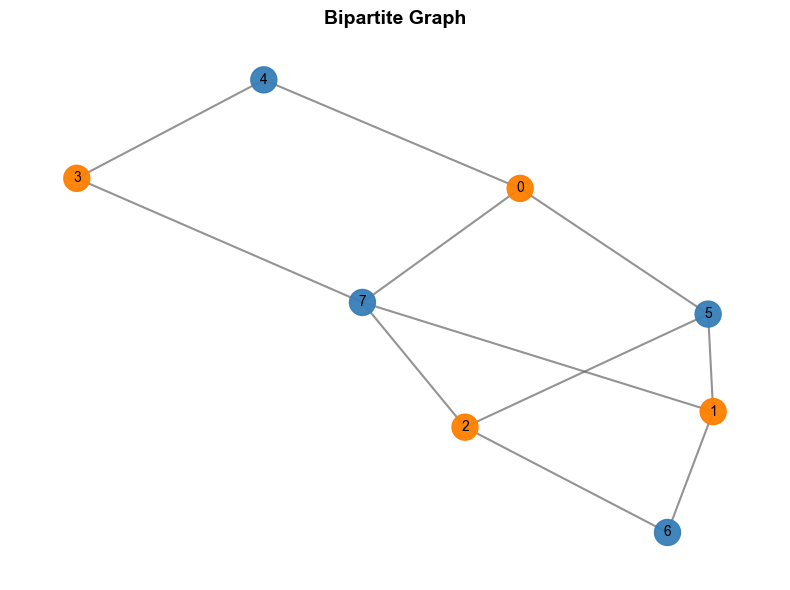

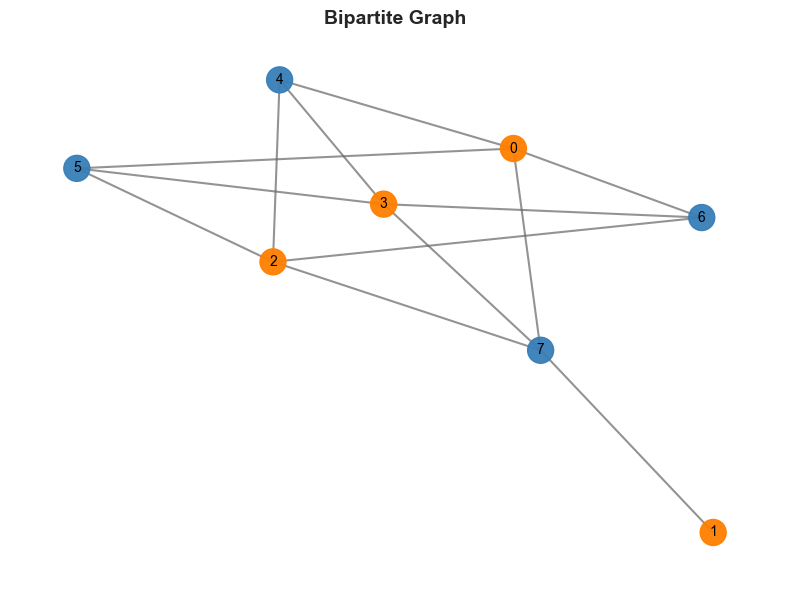

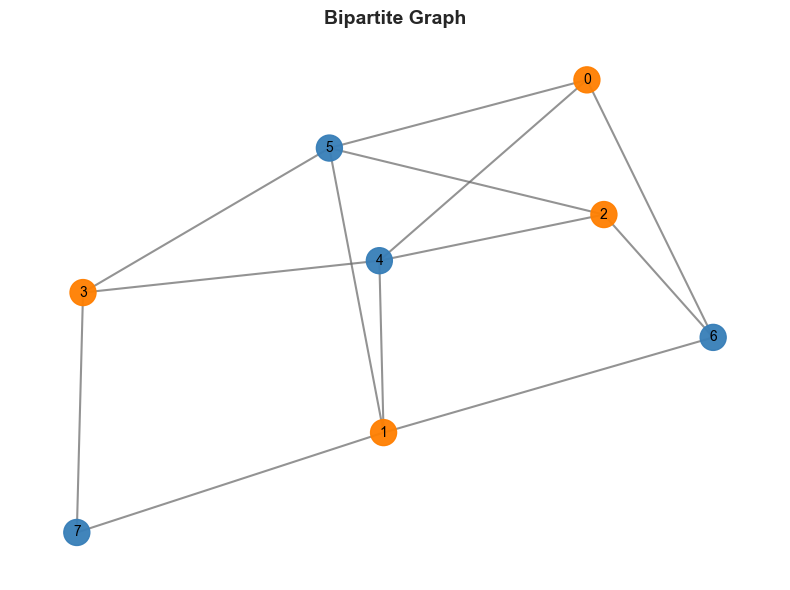

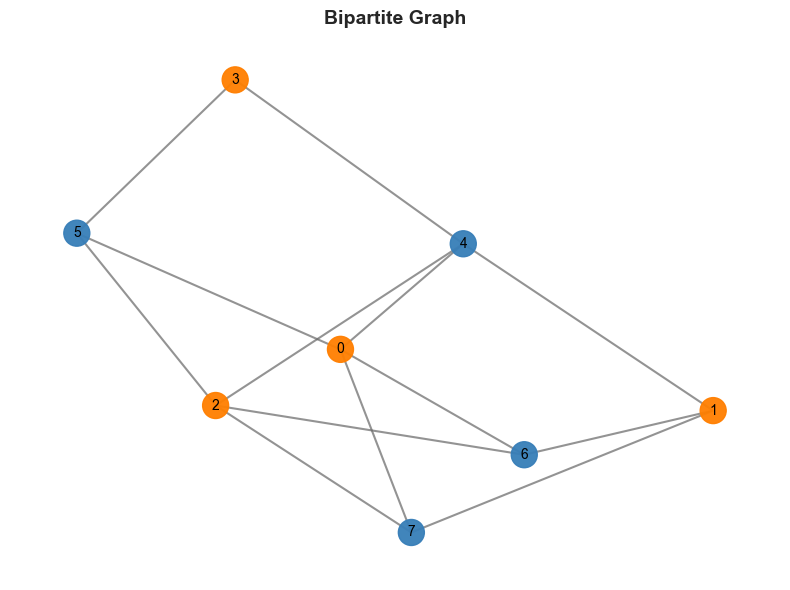

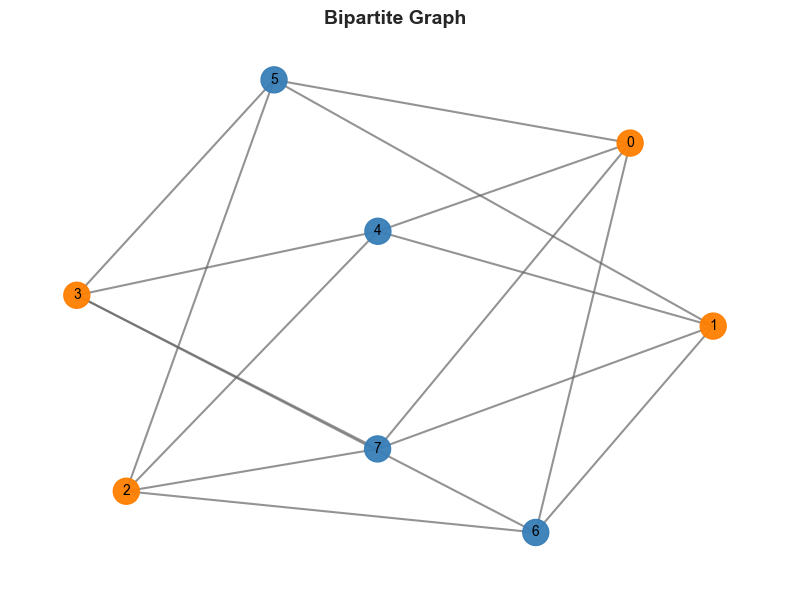

In [8]:
train_ds, _ = dataset.get_all_data()

train_ds = jnp.array(train_ds)

for idx in range(5):
    plot_graph(vec_to_graph(train_ds[idx], nodes))

In [9]:
SIGMA_MULTIPLIER = 1.7404
INIT_MULTIPLIER = 0.053727
LEARNING_RATE = 0.023320

In [10]:
sigma = median_heuristic(train_ds) * SIGMA_MULTIPLIER
params_init = initialize_from_data(gates, jnp.array(train_ds)) * INIT_MULTIPLIER

In [11]:
loss_kwarg = {
    "params": params_init,
    "iqp_circuit": circ,
    "ground_truth": train_ds,
    "sigma": [sigma],
    "n_ops": 1000,
    "n_samples": 1000,
    "key": jax.random.PRNGKey(42),
}

In [12]:
loss = genq.mmd_loss_iqp

trainer = iqp.Trainer("Adam", loss, stepsize=LEARNING_RATE)
trainer.train(n_iters= 500,loss_kwargs=loss_kwarg, turbo=1)

Training Progress: 100%|██████████| 500/500 [00:07<00:00, 63.63it/s, loss=-0.000567, elapsed time=0.01, total time=8.51]


Training has not converged after 500 steps


In [13]:
trained_params = trainer.final_params

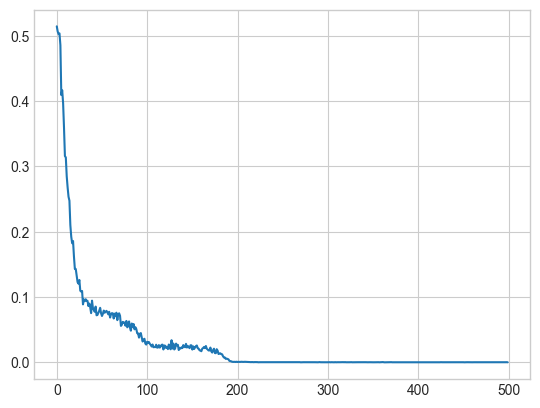

In [14]:
import matplotlib.pyplot as plt
plt.plot(trainer.losses)
plt.show() 

# Eval


Bipartite Dataset (k=8, p=0.8, connected=True):
Target samples: 256, Generated samples: 256
Bipartite: 256, Non-Bipartite: 0
Target Ratio (Bipartite): 1.000, Actual Ratio: 1.000


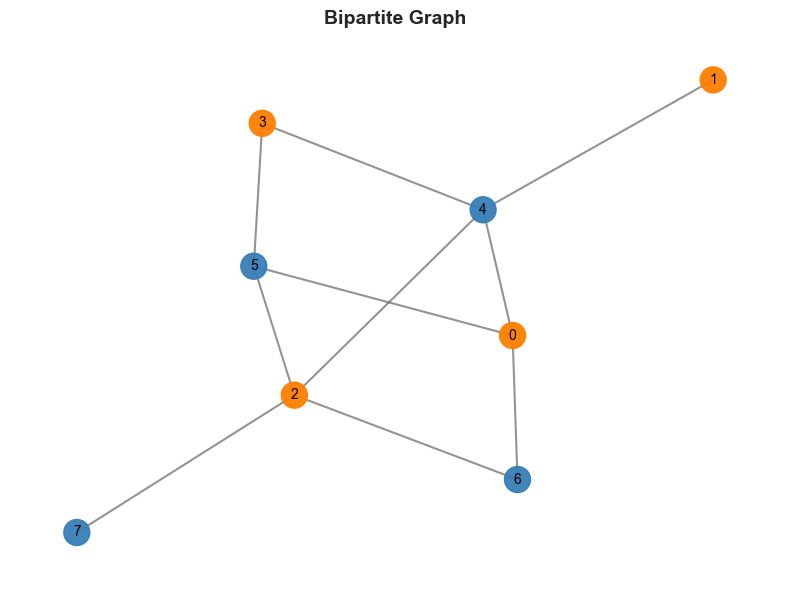

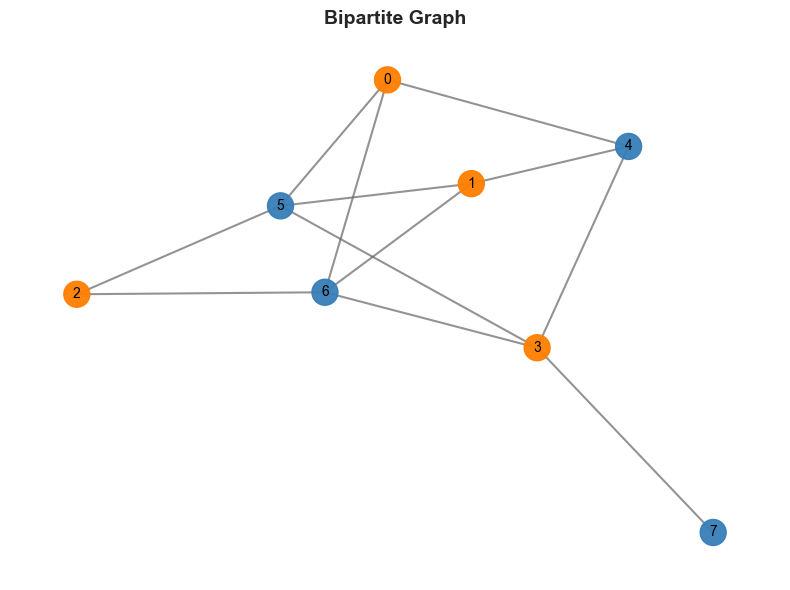

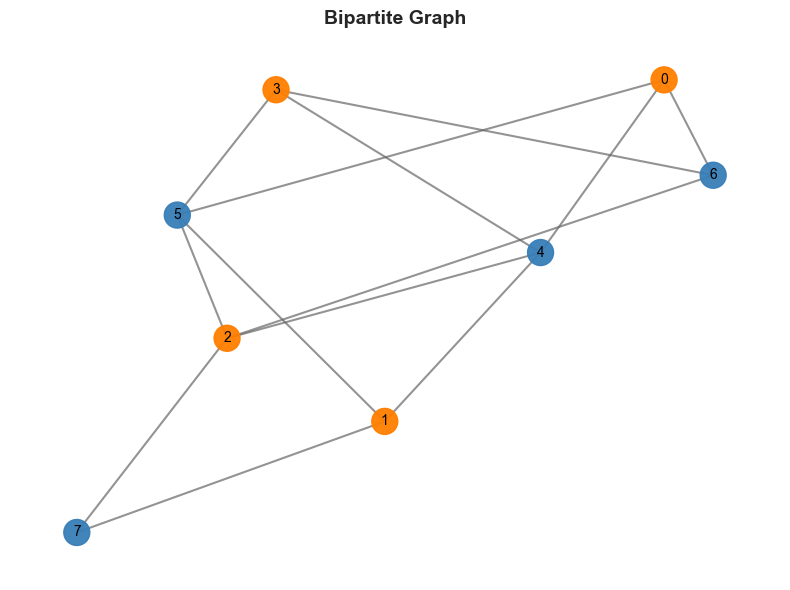

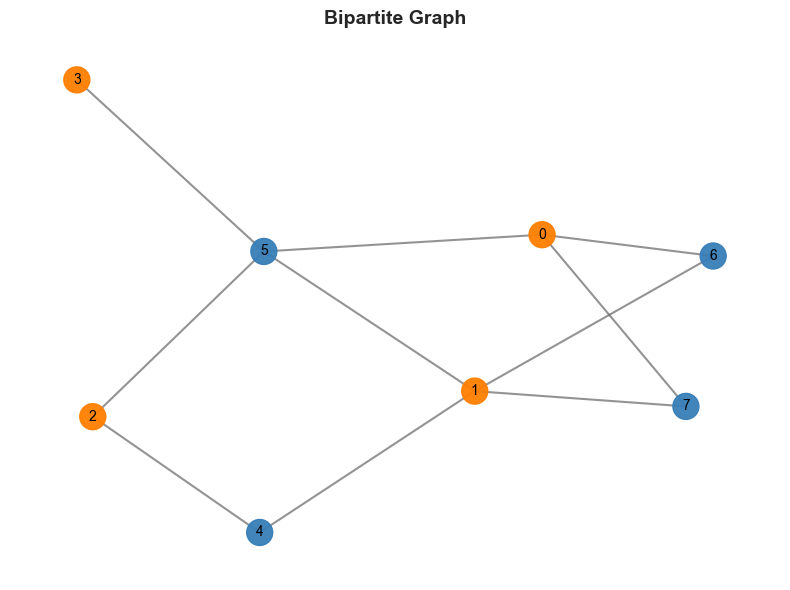

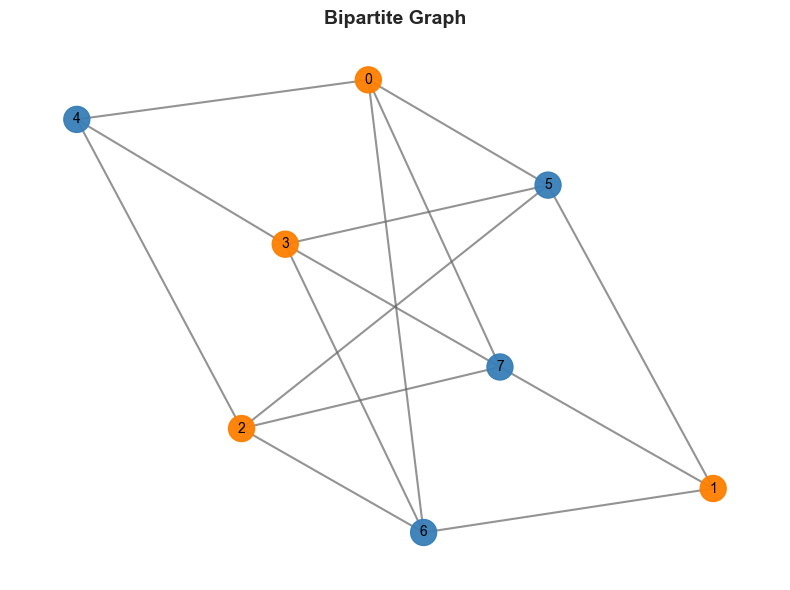

In [15]:
test_dataset = BipartiteGraphDataset(num_samples=256,
                                num_vertices=nodes,
                                ratio_bipartite=1.0,
                                edge_prob=0.8)

test, _ = test_dataset.get_all_data()

test = jnp.array(test)

for idx in range(5):
    plot_graph(vec_to_graph(test[idx], nodes))

In [16]:
samples = circ.sample(trained_params, shots = 256)

In [17]:
from utils import metrics

## Proportion of bipartites

In [18]:
metrics.bipartite_proportion(samples, nodes)

0.9921875

## KL divergence

In [19]:
ground_truth = [vec_to_graph(g, nodes) for g in train_ds]
generated_samples = [vec_to_graph(g, nodes) for g in samples]

metrics.average_kl_divergence(ground_truth, generated_samples)

2.333120332528412

In [20]:
ground_truth_test = [vec_to_graph(g, nodes) for g in test]

metrics.average_kl_divergence(ground_truth_test, generated_samples)

2.3207120518744846

In [21]:
metrics.average_kl_divergence(ground_truth_test, ground_truth)

2.7250798241299146

## Data diversity

In [22]:
metrics.memorized_proportion(ground_truth, generated_samples)

0.0546875

In [23]:
metrics.memorized_proportion(ground_truth, ground_truth_test)

0.06640625

In [24]:
metrics.sample_diversity(generated_samples)

0.1796875

In [25]:
metrics.sample_diversity(generated_samples, "jaccard")

0.33708751825235106